# Work for Tom Sargent
By Brandon Kaplowitz

Date: June 1, 2018 

## Problem 1.1 from "Marching Orders"
### Description of the Problem
We take from 0 to T $$y_t=\theta_ty_{t-1} + \varepsilon_t$$ $$ \theta_{t+1} = \theta_t+\nu_t $$
where  
$$
\begin{equation}
\left(\begin{matrix}
\varepsilon_t \\
\nu_t 
\end{matrix}\right) \sim \mathcal{N}\left(0,V\right) \ \text{and}  \ V= \left[ \begin{matrix} 
R & C \\
C & Q 
\end{matrix}\right].
\end{equation}
$$
We suppose initial state $\theta_0$ and $V$ are independent and their natural conjugate priors are
 $$\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta},\bar{P}\right) $$
 and 
 $$ V\sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$$ 
 where $\mathcal{IW}\left(S,df\right)$ is the inverse wishart distribution with scale matrix $S$ and degrees of freedom $df$. We suppose that $\left(\bar{\theta}, \bar{P}, \bar{V}^{-1} , T_0\right)$ are known and fixed.
 
 We  treat $\theta_t$ as a hidden state variable following a driftless random walk with the truncated Gaussian distribution:
 
 $$p\left(\theta_{t+1}|\theta_t,V\right) \propto \mathbb{1}_{|\theta_{t+1}| <1} \mathcal{N}\left(\theta_t,Q\right).$$
 
### Description of Algorithm

To solve this problem, we need to take the priors $\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta}, \bar{P}\right)$ and $V \sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$ and multiply them by their likelihoods to find their posteriors. The posterior is $$p\left(\theta^T,V|y^T\right) \underbrace{=}_{\text{By Bayes' Rule}} \frac{p\left(y^T|\theta^T,V\right)p\left(\theta^T,V\right)}{p\left(y^T\right)}= \frac{p\left(y^T|\theta^T,V
\right)p\left(\theta^T|V\right)p\left(V\right)}{p\left(y^T\right)}$$
$$ =\frac{\prod_{t=1}^{T}p\left(y_t|y_{t-1},\theta^T,V\right)\prod_{t=1}^{T}p\left(\theta_{t+1}|\theta_{t},V\right)p\left(\theta_0\right)p\left(V\right)}{p\left(y^T\right)} $$
We can see now that the first term is the likelihood, the second the Bayesian updating of $\theta$ from a prior on $\theta$ to a posterior on $\theta_t$ given the $\theta$ before it, and the last two terms the prior for $\theta_0$ and $V$. 
Note that: $$p\left(y_t|y_{t-1}, \theta^T,V\right)=  p\left(\theta_t y_{t-1}+\varepsilon_t|\theta_t, y_{t-1},\varepsilon_{t-1} \right)\underbrace{=}_{iid}p\left(\varepsilon_t\right) \sim \mathcal{N}\left(\theta_t y_{t-1},R\right)$$
$$p\left(\theta_{t+1} | \theta_{t},V\right) \propto \mathbb{1}_{|\theta_{t+1}|<1}\mathcal{N}\left(\theta_t,Q\right)$$

The procedure we use is as follows. We use a modification to MCMC called HMC, as well as the Metropolis-Hastings for speed comparison. We compute the numerator of the fraction given above to give a conditional pdf. We then take a proposal distribution, draw a new point from the proposal. If the ratio of the numerator of the new point to the old point is greater than 1 we accept. Otherwise we accept with the probability of the ratio times a correction for asymmetric distributions. We can ignore the denominator as we are examining the ratio of two pdfs, both of which will have the same denominator, which is a normalization.
We now implement this procedure in PYMC3.
## Implementation

To actually implement this model, since $p(y_t|y_{t-1},\theta^T,V)$ is incredibly difficult to calculate explicitly, we will use the built in Hierarchical GLM modeller in PYMC3. 

The model we will use looks as follows:

![title](Source.gv.png)

In [1]:
%reset -f
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib
from matplotlib import rc
import seaborn as sns
import theano as theano
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pylab as plt 
plt.rc('mathtext', fontset="cm")
import scipy.stats as st
from pymc3.distributions import Continuous, Normal, MvNormal

import theano.tensor as tt
from theano import scan
from pymc3.util import get_variable_name
from pymc3.distributions.continuous import get_tau_sd, Normal, Flat
from pymc3.distributions.dist_math import Cholesky
from pymc3.distributions import multivariate
from pymc3.distributions import distribution
matplotlib.rcParams['font.sans-serif']='DejaVu Sans'
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.style.use('ggplot')

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
/Users/bkaplowitz-local/anaconda3/envs/idp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
T=50
theta_true=np.empty([T+1,1])
nu=np.empty([T+1,1])
y_obs=np.empty([T+1,1])
y_obs_last = np.empty([T+1,1])
y_obs[0]=0
y_obs_last[0]=0
theta_true[0]=.3
errs=st.multivariate_normal.rvs(mean=[0.,0.], cov=[[2.0, 0.3], [0.3, 0.5]], size=T+1)
nu=errs[:,0]
err=errs[:,1]
for t in range(1,T):
    theta_true[t+1]=theta_true[t]+nu[t]
    while (theta_true[t+1]>1 or theta_true[t+1]<-1):
        theta_true[t+1]=st.norm.rvs(loc=theta_true[t], scale=np.sqrt(.5))
    y_obs[t]= theta_true[t]*y_obs[t-1]+err[t]
    y_obs_last[t]=y_obs[t-1]

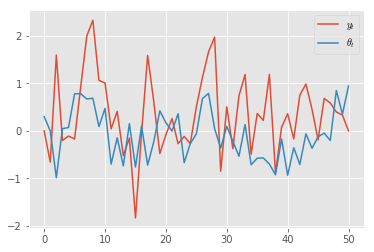

In [3]:
plt.plot(y_obs, label=r'$y_t$') 
plt.plot(theta_true,label=r'$\theta_t$')
plt.legend()

In [4]:
#define the likelihood function used
class univautoreg(Continuous):
    def __init__(self,theta0=None, chol=None, *args, **kwargs):
        super(univautoreg, self).__init__(*args, **kwargs)
        self.theta0 = theta0
        v=chol.dot(chol.T)
        self.v = v
        T=50 #number of samples
        self.mean = tt.as_tensor_variable(0.)
        sd =tt.sqrt(tt.diag(v))
        sdnew = tt.sum(tt.set_subtensor(sd[0],sd[1]))/2
        BoundedNormal = pm.Bound(pm.Normal, lower=-1, upper=1)
        nu=BoundedNormal('nu',mu=0., sd= sdnew)
        self.nu = nu
        self.sd = sdnew
        def calc_next_theta(last_theta,nu):
            theta=last_theta + nu
            last_theta=theta
            return theta
        thetas_list, _ = scan(fn=calc_next_theta, 
                             outputs_info=[theta0],
                             n_steps=T,
                             non_sequences=[nu]
                             )
        theta=thetas_list
        self.theta=theta
    def logp(self,value):
        nu = self.nu
        theta=self.theta
        theta0=self.theta0
        v=self.v
        valuenew=value.flatten()
        def calc_next_err(last_value,value,theta_t,theta_t1,v):
            this_period=[value,theta_t1]
            meanval=theta_t*last_value
            last_period=[meanval,theta_t]
            new_last=pm.math.stack(last_period)
            new_this=pm.math.stack(this_period)
            err = new_this-new_last
            lik= MvNormal.dist(mu=np.zeros(2), cov=v).logp(err)
            return lik
        err_like, _  = scan(fn=calc_next_err,
                         sequences=[dict(input=valuenew, taps=[0,-1]),dict(input=theta, taps=[0,-1])],
                         outputs_info=[None],
                         non_sequences=[v]
                        )
        #errs=pm.math.stack(errout)
        #thetas=pm.math.stack(theta)
        liketotal=err_like.sum()
        return (liketotal)
        '''
  
                return (tt.sum(Normal.dist(mu=0.,sd=Q).logp(eps))+self.theta_lik_get(R,theta,theta_0)+Normal.dist(mu=0.,sd=Q).logp(y[0]))
        ''' 

In [ ]:
#Parameters needed to make model work.
theta_bar = .5
P_bar = .4
P_bar_sd = np.sqrt(P_bar)
V_bar = [[2,3],[3,4]]
T_0 =.2
with pm.Model() as model1:
    #Variance function
    sd_dist= pm.HalfCauchy.dist(beta=2.5)
    BoundedNormal = pm.Bound(pm.Normal, lower=-1, upper=1)
    packed_chol = pm.LKJCholeskyCov('packed_chol', n=2, eta= 1, sd_dist=sd_dist ) #equivalent of p(V)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
 # does chol*chol^T to recover variance matrix, chol here is Lower matrix.
    theta_prior= BoundedNormal('theta_prior',mu=theta_bar, sd=P_bar_sd)
    like = univautoreg('like', theta0=theta_prior, chol=chol, observed=y_obs)
    start = pm.find_MAP()
    step = pm.Metropolis()
    tracemodel1 = pm.sample(10000,step, start=start)

logp = -7.4487e+12, ||grad|| = 8.2423e+17: 100%|██████████| 90/90 [00:02<00:00, 30.54it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu_interval__]
>Metropolis: [theta_prior_interval__]
>Metropolis: [packed_chol_cholesky_cov_packed__]
 70%|███████   | 7383/10500 [03:31<01:29, 34.95it/s]

In [13]:
pm.summary(tracemodel1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
packed_chol__0,1.006969e+00,7.824595e-02,7.824440e-03,9.069089e-01,1.127565e+00,2.002320,43.312925
packed_chol__1,-1.181104e-11,1.711469e-09,7.613668e-11,-3.652363e-09,3.256196e-09,374.989551,1.006644
packed_chol__2,9.200619e-09,1.584021e-09,1.573905e-10,7.450742e-09,1.108840e-08,2.031527,8.631543
theta_prior,7.403432e-02,1.750320e-01,1.750316e-02,-2.056008e-01,2.359458e-01,2.001163,124.561784
nu,-5.729216e-11,1.432546e-09,7.040915e-11,-2.869990e-09,2.663546e-09,332.164154,1.007505


In [7]:
pm.hpd(tracemodel1)

{0: {'packed_chol_cholesky_cov_packed__': array([[-2.08811964e-02, -1.33749333e-02],
         [-1.92278256e-09,  2.62194780e-09],
         [-1.87149522e+01, -1.86437193e+01]]),
  'theta_prior_interval__': array([-0.41872861, -0.41152302]),
  'nu_interval__': array([-4.55031465e-09,  5.03071815e-09]),
  'packed_chol': array([[ 9.79335306e-01,  9.86714114e-01],
         [-1.92278256e-09,  2.62194780e-09],
         [ 7.45074185e-09,  8.00084040e-09]]),
  'theta_prior': array([-0.20635795, -0.20290603]),
  'nu': array([-2.27515740e-09,  2.51535903e-09])},
 1: {'packed_chol_cholesky_cov_packed__': array([[ 3.82456737e-03,  1.21105010e-02],
         [-3.80152831e-09,  4.03715246e-09],
         [-1.83681969e+01, -1.83021058e+01]]),
  'theta_prior_interval__': array([0.42010023, 0.43400236]),
  'nu_interval__': array([-5.97647319e-09,  6.01176766e-09]),
  'packed_chol': array([[ 1.00383189e+00,  1.01218413e+00],
         [-3.80152831e-09,  4.03715246e-09],
         [ 1.05388551e-08,  1.1258912

In [8]:
pm.quantiles(tracemodel1)

{0: {'packed_chol_cholesky_cov_packed__': {2.5: array([-2.08115716e-02, -2.07890145e-09, -1.87146391e+01]),
   25: array([-1.75979809e-02, -6.71017714e-10, -1.87093603e+01]),
   50: array([-1.64524891e-02,  1.34719463e-10, -1.87017631e+01]),
   75: array([-1.53367648e-02,  9.42804426e-10, -1.86850251e+01]),
   97.5: array([-1.31893211e-02,  2.56708741e-09, -1.86280025e+01])},
  'theta_prior_interval__': {2.5: -0.41864755660802394,
   25: -0.41588237617745616,
   50: -0.4141759295222486,
   75: -0.412617606867184,
   97.5: -0.41138581181056294},
  'nu_interval__': {2.5: -4.784011902969054e-09,
   25: -2.269720648038444e-09,
   50: -5.215555604692702e-10,
   75: 1.1978406936910055e-09,
   97.5: 4.960141433652e-09},
  'packed_chol': {2.5: array([ 9.79403495e-01, -2.07890145e-09,  7.45307525e-09]),
   25: array([ 9.82555959e-01, -6.71017714e-10,  7.49252240e-09]),
   50: array([9.83682114e-01, 1.34719463e-10, 7.54966151e-09]),
   75: array([9.84780244e-01, 9.42804426e-10, 7.67709155e-09]),

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa2f9c29e8>,
      dtype=object)

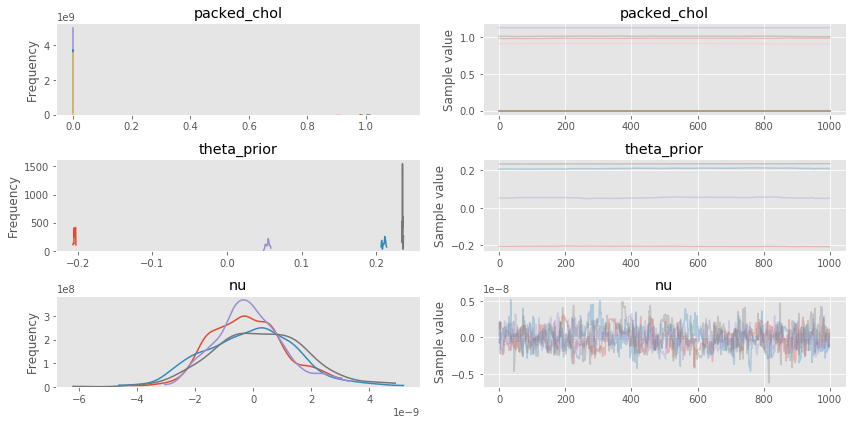

In [9]:
pm.traceplot(tracemodel1[:], alpha=.3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa30576128>,
      dtype=object)

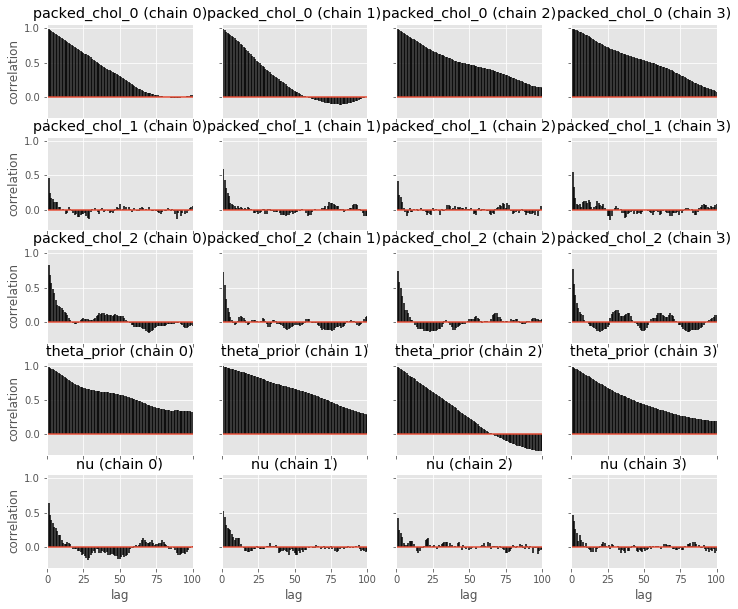

In [10]:
pm.autocorrplot(tracemodel1[10::2])

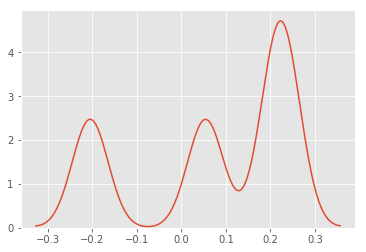

In [11]:
sns.kdeplot(tracemodel1[::2]['theta_prior'])

In [12]:
sns.kdeplot(tracemodel1[::2][''])

KeyError: 'Unknown variable sd'

In [ ]:
sns.kdeplot(tracemodel1[::2]['nu'])

In [ ]:
#sns.kdeplot(tracemodel1[1000::10]['V'])

In [ ]:
trace=pm.sample(1000, model=model1, step=stepper)
pm.traceplot(trace)
postpred=pm.sample_ppc(trace, samples=1000, model=model1)
model1.free_RVs

In [ ]:
model1.observed_RVs

In [ ]:
postpred[''][:10]

In [ ]:
plt.hist(postpred['like_y'], alpha=0.2, normed=True)
sns.kdeplot(tr1['mu']);